In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [48]:
df=pd.read_csv(r'/gdrive/My Drive/time_series_sales/perrin-freres-monthly-champagne.csv')


In [49]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [50]:
df.isnull().sum()

Month                                                     1
Perrin Freres monthly champagne sales millions ?64-?72    2
dtype: int64

In [51]:
df.dropna(inplace=True)

In [52]:
df.isnull().any()

Month                                                     False
Perrin Freres monthly champagne sales millions ?64-?72    False
dtype: bool

In [53]:
df.columns=['month','sale']
df.head()

,month,sale
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [54]:
df['month']=pd.to_datetime(df['month'])

In [55]:
df.set_index('month',inplace=True)

In [56]:
df.head()

,sale
month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


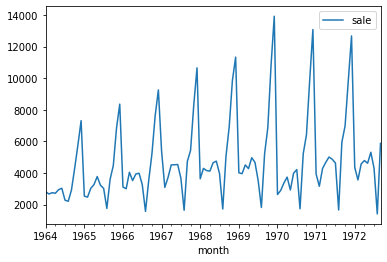

In [57]:
df.plot()

In [58]:
#testing for stationary data

from statsmodels.tsa.stattools import adfuller


In [59]:
test_result=adfuller(df['sale'])

In [60]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sale):
    result=adfuller(sale)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [61]:
adfuller_test(df['sale'])


ADF Test Statistic : -1.833593056327624
p-value : 0.36391577166024447
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [43]:
#Differencing

In [63]:
df['sale First Difference'] = df['sale'] - df['sale'].shift(1)

In [64]:
df['sale First Difference']

month
1964-01-01       NaN
1964-02-01    -143.0
1964-03-01      83.0
1964-04-01     -34.0
1964-05-01     225.0
               ...  
1972-05-01    -170.0
1972-06-01     694.0
1972-07-01   -1014.0
1972-08-01   -2885.0
1972-09-01    4464.0
Name: sale First Difference, Length: 105, dtype: float64

In [65]:
df['seasonal First Difference'] = df['sale'] - df['sale'].shift(12)

In [67]:
adfuller_test(df['seasonal First Difference'].isnull())

ADF Test Statistic : 2.8640525838044932
p-value : 1.0
#Lags Used : 0
Number of Observations Used : 104
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [69]:
adfuller_test(df['sale First Difference'].isnull())

ADF Test Statistic : 3.016431955284114e+16
p-value : 1.0
#Lags Used : 0
Number of Observations Used : 104
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


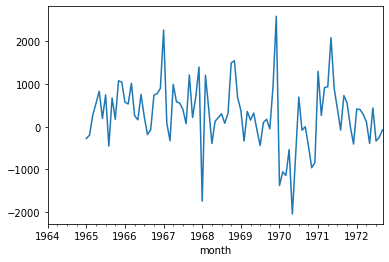

In [71]:
df['seasonal First Difference'].plot()

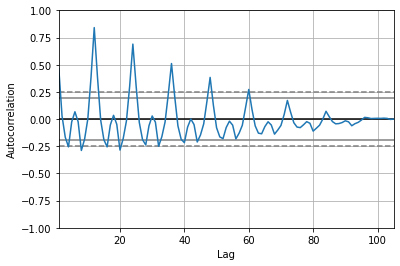

In [75]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['sale'])
plt.show()

In [86]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


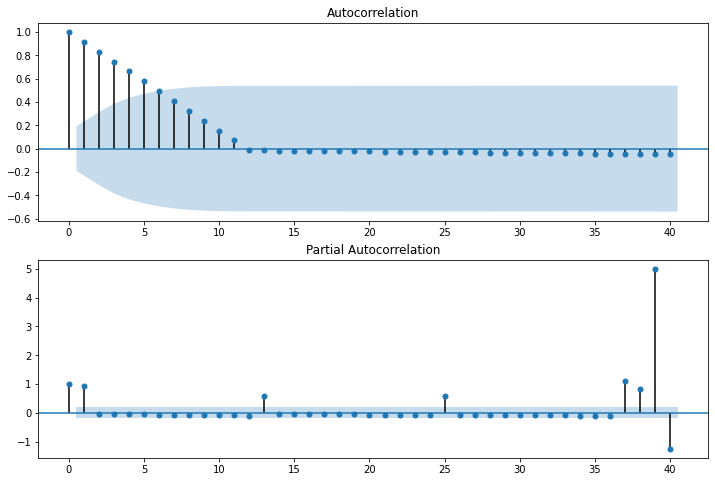

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['seasonal First Difference'].isnull(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['seasonal First Difference'].isnull(),lags=40,ax=ax2)

In [93]:
model=sm.tsa.statespace.SARIMAX(df['sale'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


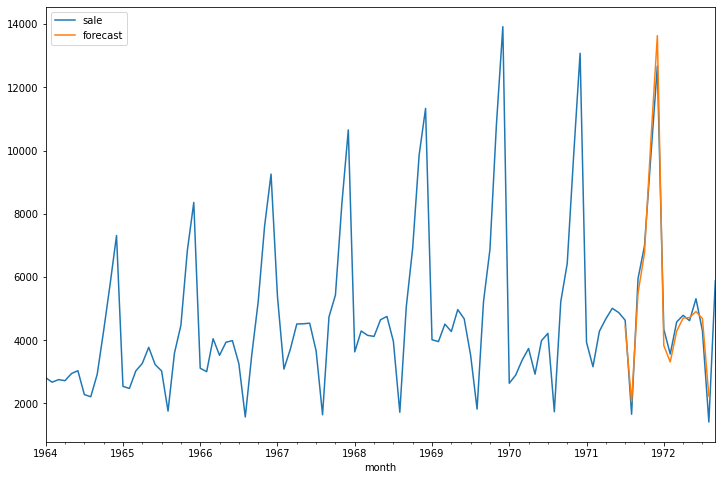

In [94]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['sale','forecast']].plot(figsize=(12,8))

In [95]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [96]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [97]:
future_datest_df.tail()

,sale,sale First Difference,seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [98]:
future_df=pd.concat([df,future_datest_df])


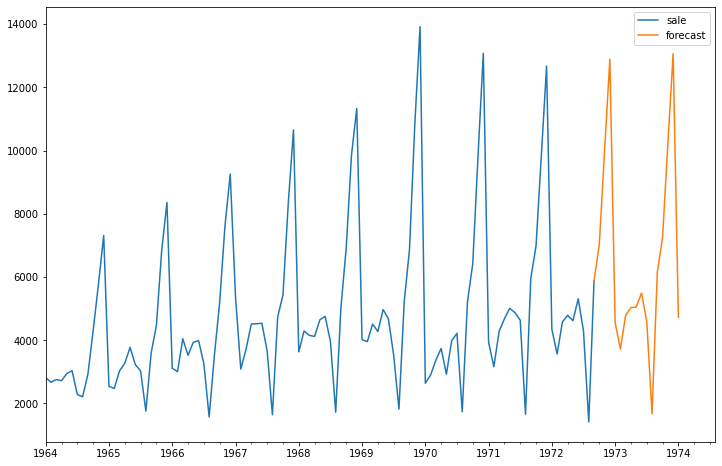

In [99]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['sale', 'forecast']].plot(figsize=(12, 8)) 